In [1]:
from braket.circuits import Circuit
from braket.aws import AwsDevice
from braket.devices import LocalSimulator
import itertools


In [2]:
def plot_histogram(counts):
    import matplotlib.pyplot as plt
    states = list(counts.keys())
    values = list(counts.values())
    plt.bar(states, values)
    plt.xlabel("Bitstring")
    plt.ylabel("Counts")
    plt.show()




In [3]:
num_q = 10
shot_number = 100

In [4]:
circuit_had = Circuit()
circuit_cnot = Circuit()
for i in range(num_q):
    circuit_had.h(i)
    circuit_cnot.h(i)

for i in range(int(num_q/2)):
    circuit_cnot.cnot(i,i+int(num_q/2))

for i in range(num_q):
    circuit_had.measure(i)
    circuit_cnot.measure(i)




In [5]:
print(circuit_had) 
print(circuit_cnot)

T  : │  0  │  1  │
      ┌───┐ ┌───┐ 
q0 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q1 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q2 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q3 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q4 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q5 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q6 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q7 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q8 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q9 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
T  : │  0  │  1  │
T  : │  0  │              1              │  2  │
      ┌───┐                               ┌───┐ 
q0 : ─┤ H ├───●───────────────────────────┤ M ├─
      └───┘   │                           └───┘ 
      ┌───┐   │                           ┌───┐ 
q1 : ─┤ H ├───┼─────●─────────────────────┤ M ├─
      └───┘   │     │                     └───┘ 
      ┌───┐   │     │                     ┌───┐ 


Counter({'0001011110': 2, '0001011000': 2, '0111110100': 2, '0100011111': 2, '0111011000': 2, '0000010100': 1, '0100111110': 1, '0111011111': 1, '1100000110': 1, '1010110000': 1, '1101001110': 1, '0001101011': 1, '0010111101': 1, '1000000110': 1, '1101110110': 1, '0100010011': 1, '1101011100': 1, '0000001110': 1, '0011101101': 1, '0100000101': 1, '1101011000': 1, '0111010110': 1, '0000010111': 1, '0100000100': 1, '0101000001': 1, '0000100111': 1, '0100011110': 1, '1100000101': 1, '1110001110': 1, '0011101110': 1, '0011000000': 1, '1100100011': 1, '1011100111': 1, '0011110101': 1, '1100000001': 1, '0111100100': 1, '0110100011': 1, '0011111000': 1, '0111000101': 1, '0000000001': 1, '1111100011': 1, '1100111011': 1, '0101011110': 1, '1001010000': 1, '1111101101': 1, '1111101011': 1, '1111110111': 1, '1000011001': 1, '1001010101': 1, '0001001101': 1, '0011000100': 1, '1001100010': 1, '1101010110': 1, '0010000110': 1, '0001001110': 1, '1001001101': 1, '1110000100': 1, '1001110101': 1, '0100

Matplotlib is building the font cache; this may take a moment.


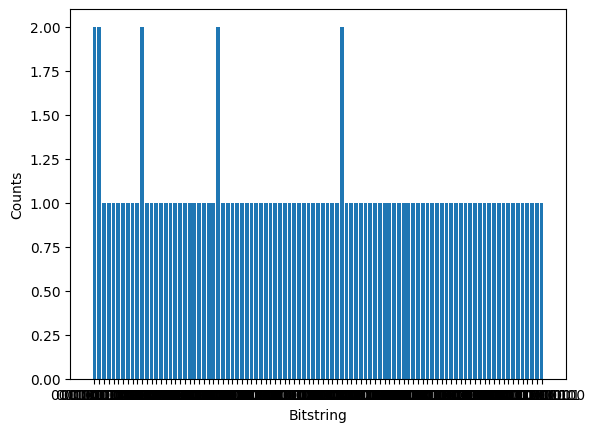

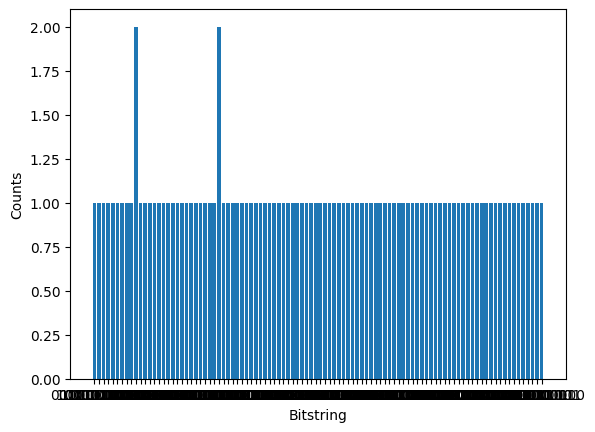

In [7]:
#run experiment

device = LocalSimulator()

   
result_had = device.run(circuit_had, shots = shot_number).result()
result_cnot = device.run(circuit_cnot,shots = shot_number).result()

print(result_had.measurement_counts)
print(result_cnot.measurement_counts)
plot_histogram(result_had.measurement_counts)
plot_histogram(result_cnot.measurement_counts)

Classical post processing of data 
must analyse hamming weight 

First, must calculate for each qubit the probablity of 1. So among the shots, what is the probablity of this qubit ot have 1 must be first coded. and encode that probablity into 5 bits information. then in total, we will have a 5 times 10, 50 bit bitstring which would be the subject of analysing intra and inter hamming distance


In [8]:
#Extract probablity of 1 for each qubit. 

def float_to_bits(x, n_bits=5):
    assert 0.0 <= x < 1.0
    integer = int(x * (2 ** n_bits))
    return format(integer, f"0{n_bits}b")


def prob1_bitstring(result, precision = 5):

    data = result.measurements
    
    num_qubit = len(data[0])
    shot_number = len(data)

    #calculate prob of 1 for each qubit
    prob_list = []
    for i in range(num_qubit):
        k = 0
        for step in range(shot_number):
            if data[step][i] == 1:
                k += 1
            else:
                continue 
        prob_list.append( float_to_bits(k/shot_number, precision ))

    bitstring = ""
    for prob in prob_list:
        bitstring += prob

    return bitstring 


def hamming_distance(a, b):
    return sum(x != y for x, y in zip(a, b))

def average_hamming_distance(bitlist):
    """
    responses: list of bitstrings from different devices

    depending on what the bitlist is, this gives either intra or inter hd. 
    For intra hd, bitlist must be the list of one device but at different time
    For inter hd, bitlist must be the list of different devices for the same challenge 
    """
    m = len(bitlist)
    n = len(bitlist[0])
    distances = []

    for r1, r2 in itertools.combinations(bitlist, 2):
        distances.append(hamming_distance(r1, r2) / n)

    return 100 * sum(distances) / len(distances)

    
def run_quantum_task(circuit, device_arn,shot_number, prefix):
    device = AwsDevice(device_arn)
    s3_bucket = "amazon-braket-quen-result-us-west-1"
    s3_prefix = "braket-test/" + prefix 

    task = device.run(
    circuit,
    shots = shot_number,
    s3_destination_folder = (s3_bucket, s3_prefix),

    )


    print(task.id)
    result = task.result()
    
    return result
    


        
    

In [9]:
print(prob1_bitstring(result_had))

10000100100111010000011010111110000101000111101111


Now, run experiments with different devices and see inter hamming distance for both circuits. Ideally, inter hamming distance should be 50 percent. 

In [10]:
numberofDevice = 4

devices = AwsDevice.get_devices()

online_device_arn_list = []

for d in devices:
    if d.status == "ONLINE" and "/qpu/" in d.arn and 'braket.ir.openqasm.program' in d.properties.action.keys() :
        online_device_arn_list.append(d)


In [11]:
for device in online_device_arn_list:
    print(device.name)
    print(device.queue_depth())

Ankaa-3
QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '5', <QueueType.PRIORITY: 'Priority'>: '0'}, jobs='0')
Emerald
QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '0', <QueueType.PRIORITY: 'Priority'>: '0'}, jobs='0')
Forte 1
QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '0', <QueueType.PRIORITY: 'Priority'>: '1'}, jobs='2')
Garnet
QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '30', <QueueType.PRIORITY: 'Priority'>: '0'}, jobs='0')
